In [1]:
!pip install catboost
!pip install --upgrade --force-reinstall numpy catboost

import importlib
import numpy
import catboost

importlib.reload(numpy)
importlib.reload(catboost)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
  Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 883.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 126.2 MB/s eta 0:00:00
Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl (99.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

load the data

In [3]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

visualize data

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


drop non-numeric and unrelated columns

In [5]:
df_train = df_train.drop(columns=["Embarked", "Cabin", "Name", "Ticket", "SibSp", "Parch"])
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare
0,1,0,3,male,22.0,7.2500
1,2,1,1,female,38.0,71.2833
2,3,1,3,female,26.0,7.9250
3,4,1,1,female,35.0,53.1000
4,5,0,3,male,35.0,8.0500


We will look at the potential of every feature.

1. PassengerID - does not have any indication to create a new feature from it.

2. Survived - is a class feature to be predicted with regard to each passengerin the test data thus no feature can be derived from it.

3. Pclass - is class feature detailing the ticket classification if 1st, 2nd, or 3rd and no feature can be got from it.

4. Sex - is categorical feature detailing passenger orientation if male or female and no feature can be created from it.

5. Age - is an ordinal unique feature showing amount of years lived and can create an AgeGroup categorical feature.

6. Fare - is a feature showing the amount paid by each passenger and can help create a FareGroup feature.

Gather Information

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   Fare         891 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 41.9+ KB


Check to see if there are any missing values.

In [7]:
1 - (df_train.count() / len(df_train))


,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Sex,0.000000
Age,0.198653
Fare,0.000000


Observations

Age has about 20% missing values which can be imputed with either mean, mode or median.

All other features do not have missing values.

Numerical columns: Shows count, mean, std (standard deviation), min, quartiles (25%, 50%, 75%), and max.
Categorical columns: Shows count, unique (number of unique values), top (most frequent value), and freq (frequency of the top value).

In [8]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,Fare
count,891.000000,891.000000,891.000000,891,714.000000,891.000000
unique,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,male,NaN,NaN
freq,NaN,NaN,NaN,577,NaN,NaN
mean,446.000000,0.383838,2.308642,NaN,29.699118,32.204208
std,257.353842,0.486592,0.836071,NaN,14.526497,49.693429
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000
25%,223.500000,0.000000,2.000000,NaN,20.125000,7.910400
50%,446.000000,0.000000,3.000000,NaN,28.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,38.000000,31.000000


Observation

Minimum fare is 0 and also seems not normal

MinMaxScaler: Scales numerical data between a specified range (default 0 to 1).
OneHotEncoder: Converts categorical variables into numerical form (dummy variables).
data = df_train[['Survived', 'Pclass', 'Sex','Age', 'Fare']]: Extracts only these columns from df_train for preprocessing.

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

data = df_train[['Survived', 'Pclass', 'Sex','Age', 'Fare']]

Add new column to change sex to numerical values

In [10]:
# One-hot encode 'Sex' into a new column 'Sex_male'
df_train['Sex_male'] = df_train['Sex'].map({'female': 0, 'male': 1})

# Create df2 as a copy of df_train
df2 = df_train.copy()

# Reverse the encoding back to original 'Sex' values
df2['Sex'] = df2['Sex_male'].map({0: 'female', 1: 'male'})


# Exploring Relationships between features and survival

Relationship between age and far shown in histograms

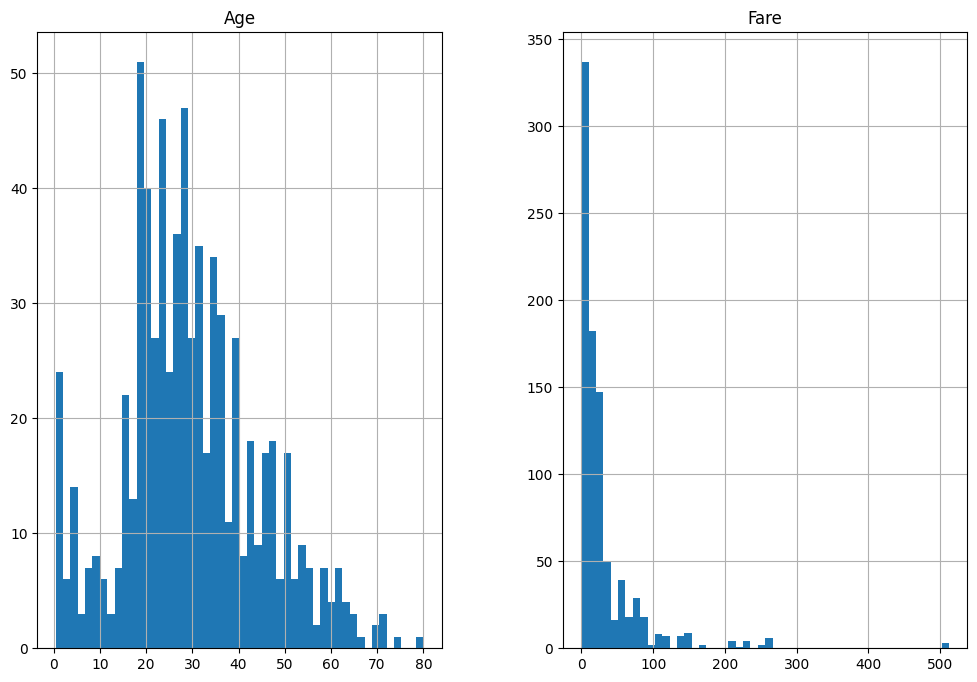

In [11]:
df_train[['Age', 'Fare']].hist(bins=50, figsize=(12, 8))
plt.show()

Relationship between the sex of those who survived in a barplot

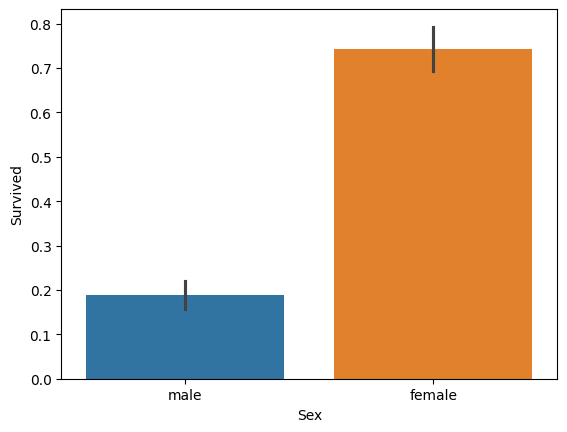

In [12]:
sns.barplot(data=df_train, x='Sex', y='Survived', hue='Sex')
plt.show()

Females had a higher likelihood of survival.

Relationship between Pclass (socioeconomic status) and survival. Shown in a barplot.

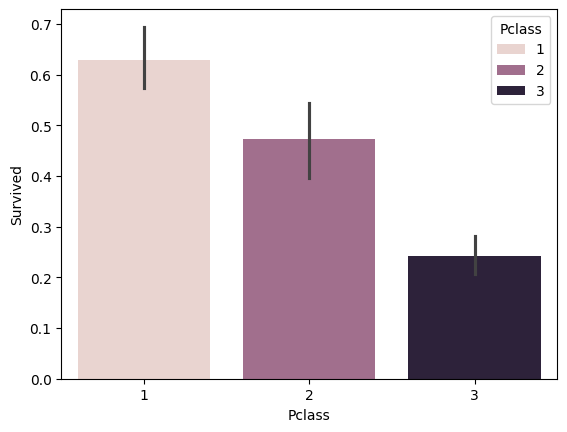

In [13]:
sns.barplot(data=df_train, x= 'Pclass', y='Survived', hue='Pclass')
plt.show()

Passenger class 1 and 2 have a higher likelihood to survive.

I created a new class feature - AgeGroup which will assist in classification of age and give the general relationship with the Survival feature. Classification will be as follows:

0-5 -> Baby

6-15 -> Child

16-35 -> Youth

36-55 -> Adult

55-80 -> Senior

In [14]:
import numpy as np

bins = [0, 6, 16, 36, 55, np.inf]
labels = ['Baby', 'Child', 'Youth', 'Adult', 'Senior']

df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=bins, labels=labels)

Relationship between AgeGroup of the survivors in a barplot.

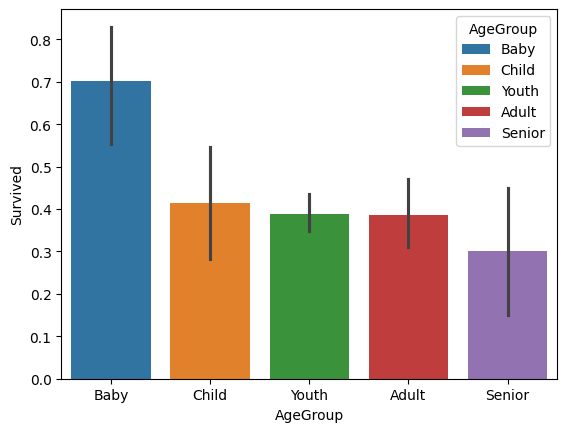

In [15]:
sns.barplot(data=df_train, x='AgeGroup', y='Survived', hue='AgeGroup')
plt.show()

- Babies have a high likelihood to survive
- Children and Adults have a similar likelihood to survive almost shared with youths
- Seniors have the lowest survival rate

There are fares which are zero which is not factual. This notebook will impute them using Pclass means.

In [16]:
df_train[['Fare', 'Pclass']][df_train['Fare'] == 0]

,Fare,Pclass
179,0.0,3
263,0.0,1
271,0.0,3
277,0.0,2
302,0.0,3
413,0.0,2
466,0.0,2
481,0.0,2
597,0.0,3
633,0.0,1


In [17]:
pclass_mean1 = round(df_train['Fare'][df_train['Pclass'] == 1].mean(), 4)
pclass_mean2 = round(df_train['Fare'][df_train['Pclass'] == 2].mean(), 4)
pclass_mean3 = round(df_train['Fare'][df_train['Pclass'] == 3].mean(), 4)
print(f'Mean 1: {pclass_mean1}, Mean 2: {pclass_mean2}, Mean : {pclass_mean3}')

Mean 1: 84.1547, Mean 2: 20.6622, Mean : 13.6756


In [18]:
df_train['Fare'][(df_train['Pclass'] == 1) & (df_train['Fare'] == 0)] = pclass_mean1
df_train['Fare'][(df_train['Pclass'] == 2) & (df_train['Fare'] == 0)] = pclass_mean2
df_train['Fare'][(df_train['Pclass'] == 3) & (df_train['Fare'] == 0)] = pclass_mean3

<ipython-input-18-fc72fd6d1b7b>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Fare'][(df_train['Pclass'] == 1) & (df_train['Fare'] == 0)] = pclass_mean1
<ipython-input-18-fc72fd6d1b7b>:1: SettingWithCopyWarning: 
A value is tryi

Histogram of fares

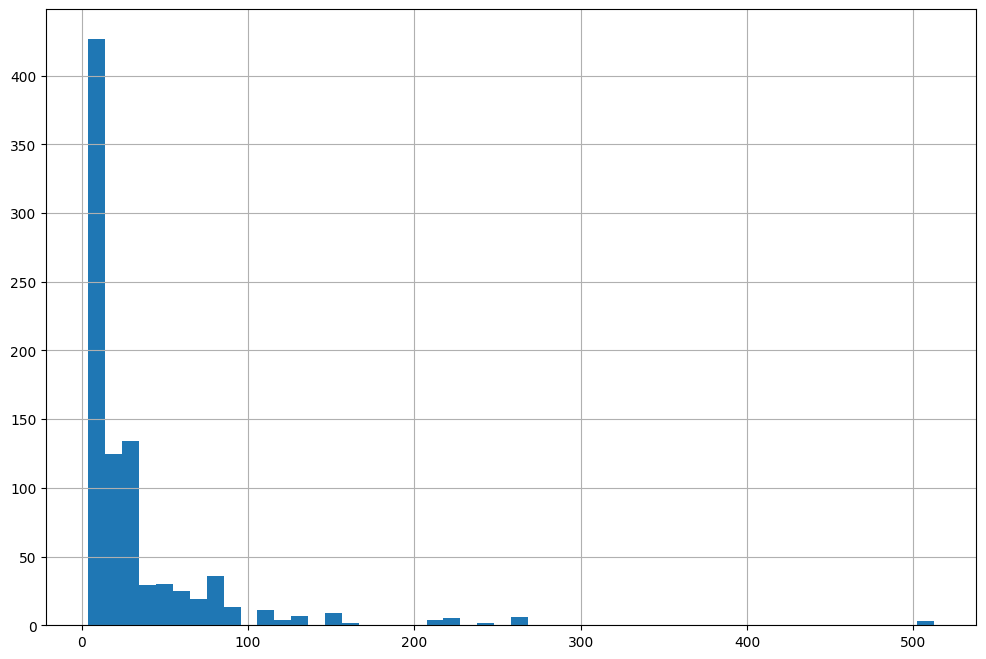

In [19]:
df_train['Fare'].hist(bins=50, figsize=(12, 8))
plt.show()

Due to the disparity of the fare this notebook will create FareGroup feature as classified as:

0-40 -> Low(1)

41-100 -> Mid(2)

101-200 -> High(3)

201-500+ -> V.High(4)

In [20]:
df_train['FareGroup'] = pd.cut(df_train['Fare'], bins = [0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4]).astype(int)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Sex_male,AgeGroup,FareGroup
0,1,0,3,male,22.0,7.2500,1,Youth,1
1,2,1,1,female,38.0,71.2833,0,Adult,2
2,3,1,3,female,26.0,7.9250,0,Youth,1
3,4,1,1,female,35.0,53.1000,0,Youth,2
4,5,0,3,male,35.0,8.0500,1,Youth,1


# Encoding Sex and AgeGroup

dummies: Converts categorical columns 'Sex' and 'AgeGroup' into numerical binary columns.
drop_first=True removes the first category to avoid multicollinearity.

inputs: Drops the original categorical columns ('Sex', 'AgeGroup').
Joins the remaining features with the new encoded variables.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_train[['Pclass', 'Sex', 'Age',
                                                                 'Fare', 'AgeGroup', 'FareGroup']], df_train[['Survived']], test_size=0.3, random_state=42)

In [22]:
dummies = pd.get_dummies(X_train[['Sex', 'AgeGroup']], drop_first=True)
inputs = pd.concat([X_train.drop(['Sex', 'AgeGroup'], axis=1), dummies], axis=1)

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [24]:
le.fit(inputs['Pclass'])
inputs['Pclass'] = le.transform(inputs['Pclass'])

# CatBoost Training for Prediction of Survival

In [25]:
from catboost import CatBoostClassifier


In [26]:
from sklearn.metrics import accuracy_score, classification_report


In [27]:
from sklearn.model_selection import cross_val_score


In [28]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean Score:', scores.mean())
    print('Std: ', scores.std())

Validating the Model

In [29]:
# Convert 'Sex' and 'AgeGroup' to string type before getting their locations
X_train['Sex'] = X_train['Sex'].astype(str)
X_train['AgeGroup'] = X_train['AgeGroup'].astype(str)

# Now get the cat_features
cat_features = [X_train.columns.get_loc(col) for col in ['Sex', 'AgeGroup'] if col in X_train.columns]

# Instantiate the CatBoostClassifier
cat_cls = CatBoostClassifier(iterations=2500, learning_rate=0.05, random_seed=42, cat_features=cat_features, verbose=False)

# Perform cross-validation
scores_cat = cross_val_score(cat_cls, X_train, y_train.values.ravel(), scoring='accuracy', cv=10)

In [30]:
display_scores(scores_cat)

Scores:  [0.80952381 0.82539683 0.85714286 0.87096774 0.79032258 0.75806452
 0.83870968 0.79032258 0.79032258 0.88709677]
Mean Score: 0.8217869943676396
Std:  0.03926133761683417


The scoring accuracy was in the 70s and 80s for sex and AgeGroup.

Adding a column.

In [31]:
# Convert 'Sex' and 'AgeGroup' to string type before getting their locations
X_train['Sex'] = X_train['Sex'].astype(str)
X_train['AgeGroup'] = X_train['AgeGroup'].astype(str)
X_train['FareGroup'] = X_train['FareGroup'].astype(str)

# Now get the cat_features
cat_features = [X_train.columns.get_loc(col) for col in ['Sex', 'AgeGroup', 'FareGroup'] if col in X_train.columns]

# Instantiate the CatBoostClassifier
cat_cls = CatBoostClassifier(iterations=2500, learning_rate=0.05, random_seed=77, cat_features=cat_features, verbose=False)

# Perform cross-validation
scores_cat = cross_val_score(cat_cls, X_train, y_train.values.ravel(), scoring='accuracy', cv=10)

Here the cv is 10.

In [32]:
display_scores(scores_cat)

Scores:  [0.79365079 0.79365079 0.84126984 0.85483871 0.79032258 0.80645161
 0.83870968 0.83870968 0.82258065 0.87096774]
Mean Score: 0.8251152073732719
Std:  0.0267615998094141


Testing another column with changed number of fits - the number of fits being 20.

In [33]:
# Convert 'Sex' and 'AgeGroup' to string type before getting their locations
X_train['Sex'] = X_train['Sex'].astype(str)
X_train['AgeGroup'] = X_train['AgeGroup'].astype(str)
X_train['FareGroup'] = X_train['FareGroup'].astype(str)

# Now get the cat_features
cat_features = [X_train.columns.get_loc(col) for col in ['Sex', 'AgeGroup', 'FareGroup'] if col in X_train.columns]

# Instantiate the CatBoostClassifier
cat_cls = CatBoostClassifier(iterations=2500, learning_rate=0.05, random_seed=100, cat_features=cat_features, verbose=False)

# Perform cross-validation
scores_cat = cross_val_score(cat_cls, X_train, y_train.values.ravel(), scoring='accuracy', cv=20)

In [34]:
display_scores(scores_cat)

Scores:  [0.8125     0.75       0.78125    0.90322581 0.96774194 0.70967742
 0.96774194 0.80645161 0.80645161 0.80645161 0.64516129 0.77419355
 0.80645161 0.87096774 0.83870968 0.80645161 0.77419355 0.90322581
 0.90322581 0.87096774]
Mean Score: 0.825252016129032
Std:  0.07865763734742372


Training the Model for Predictions

In [35]:
# Cell ipython-input-28-8eac5d7e297e
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_train[['Pclass', 'Sex', 'Age',
                                                                 'Fare', 'AgeGroup', 'FareGroup']], df_train[['Survived']], test_size=0.3, random_state=42)
dummies = pd.get_dummies(X_train[['Sex', 'AgeGroup']], drop_first=True)
inputs = pd.concat([X_train.drop(['Sex', 'AgeGroup'], axis=1), dummies], axis=1) # Define 'inputs' here

# ... (Other code cells) ...

# Cell ipython-input-1-8eac5d7e297e
from sklearn.model_selection import train_test_split
# ... (Rest of the code in the cell) ...

Hyperparameter Tuning with CatBoost

In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

In [37]:
# Define the parameter grid for CatBoost
cat_param_grid = {
    'iterations': [1000, 1600, 2000, 2400],
    'learning_rate': [0.01, 0.03, 0.05],
    'random_state': [8, 16, 42],
}

In [38]:
# Ensure 'Sex' and 'AgeGroup' are categorical
X_train['Sex'] = X_train['Sex'].astype(str)
X_train['AgeGroup'] = X_train['AgeGroup'].astype(str)

# Define categorical feature columns
cat_features = ['Sex', 'AgeGroup']

In [39]:
# Split data if X_test is missing
if 'X_test' not in locals():
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [40]:
# Ensure 'Sex' and 'AgeGroup' in X_test are also strings
X_test['Sex'] = X_test['Sex'].astype(str)
X_test['AgeGroup'] = X_test['AgeGroup'].astype(str)

In [41]:
# Initialize CatBoostClassifier with categorical features
cat_cls = CatBoostClassifier(verbose=False, cat_features=cat_features)

In [42]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
# Use GridSearchCV to perform hyperparameter tuning
grid_search = GridSearchCV(cat_cls, cat_param_grid, cv=cv, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model found by GridSearchCV
best_cat_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [44]:
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'iterations': 2000, 'learning_rate': 0.03, 'random_state': 42}


In [45]:
# Make predictions with the best model
y_pred = best_cat_model.predict(X_test)

 Tunes the hyperparameters of CatBoostClassifier with StratifiedKFold cross-validation

In [46]:
cv_result = []  # Initialize cv_result as an empty list
best_estimators = [] # Initialize best_estimators as an empty list

clf2 = GridSearchCV(CatBoostClassifier(cat_features=cat_features, verbose=False), param_grid=cat_param_grid,
                    scoring='accuracy', n_jobs=-1, cv=StratifiedKFold(n_splits=10))
clf2.fit(X_train, y_train.values.ravel())
cv_result.append(clf2.best_score_)
best_estimators.append(clf2.best_estimator_)

Result using CatBoost

In [47]:
result = pd.DataFrame({'Mean Score': cv_result, 'Model': ['CatBoost']})

Showcases mean score for CatBoost Model

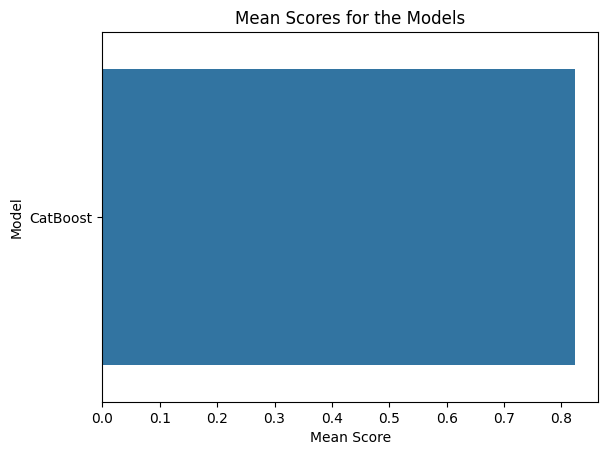

In [48]:
g = sns.barplot(data=result, x='Mean Score', y='Model')
g.set_xlabel('Mean Score')
g.set_title('Mean Scores for the Models')
plt.show()

Validating Model

In [49]:
dummies_ = pd.get_dummies(X_valid[['Sex',  'AgeGroup']], drop_first=True)
inputs_valid = pd.concat([X_valid.drop(['Sex', 'AgeGroup'], axis=1), dummies_], axis=1)

In [50]:
inputs_valid['Pclass'] =le.transform(inputs_valid['Pclass'])
inputs_valid.head()

,Pclass,Age,Fare,FareGroup,Sex_male,AgeGroup_Child,AgeGroup_Youth,AgeGroup_Adult,AgeGroup_Senior
709,2,NaN,15.2458,1,True,False,False,False,False
439,1,31.0,10.5000,1,True,False,True,False,False
840,2,20.0,7.9250,1,True,False,True,False,False
720,1,6.0,33.0000,1,False,False,False,False,False
39,2,14.0,11.2417,1,False,True,False,False,False


# Predicting Survival of the Passengers in the Test Data

In [51]:
X_train.shape

(498, 6)

In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Inputing missing values into the Test Dataset

In [53]:
data1 = df_test[['Pclass', 'Sex','Age', 'Fare']]

In [54]:
data1.head()

,Pclass,Sex,Age,Fare
0,3,male,34.5,7.8292
1,3,female,47.0,7.0000
2,2,male,62.0,9.6875
3,3,male,27.0,8.6625
4,3,female,22.0,12.2875


Sex and Pclass encoding

In [55]:
seencoding = pd.get_dummies(data1[['Sex', 'Pclass']], drop_first=True)
data_tst = pd.concat([data1.drop(['Sex', 'Pclass'], axis=1), seencoding], axis=1)

In [56]:
data_tst.shape

(418, 4)

In [57]:
# Scaling
scaler1 = MinMaxScaler()
tst_fmd = scaler1.fit_transform(data_tst)
data_tst1 = pd.DataFrame(data=tst_fmd, columns=data_tst.columns)

In [58]:
data_tst1.head()

,Age,Fare,Pclass,Sex_male
0,0.452723,0.015282,1.0,1.0
1,0.617566,0.013663,1.0,0.0
2,0.815377,0.018909,0.5,1.0
3,0.353818,0.016908,1.0,1.0
4,0.287881,0.023984,1.0,0.0


In [59]:
test_data = data_tst1.copy()  # Assuming data_tst1 is your processed test data
test_data.columns, X_train.columns  # Now this line should work

(Index(['Age', 'Fare', 'Pclass', 'Sex_male'], dtype='object'),
 Index(['Pclass', 'Sex', 'Age', 'Fare', 'AgeGroup', 'FareGroup'], dtype='object'))

In [60]:
test_data[['Fare', 'Pclass']][test_data['Fare'] == 0]

,Fare,Pclass
266,0.0,0.0
372,0.0,0.0


In [61]:
pclass_mean1t = round(test_data['Fare'][test_data['Pclass'] == 1.0].mean(), 4)

In [62]:
test_data['Fare'][(test_data['Fare'] == 0) & (test_data['Pclass'] == 1)] =pclass_mean1t

<ipython-input-62-bf2ff37693be>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_data['Fare'][(test_data['Fare'] == 0) & (test_data['Pclass'] == 1)] =pclass_mean1t


In [63]:
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins = bins, labels = labels)

In [64]:
test_data.head()

,Age,Fare,Pclass,Sex_male,AgeGroup
0,0.452723,0.015282,1.0,1.0,Baby
1,0.617566,0.013663,1.0,0.0,Baby
2,0.815377,0.018909,0.5,1.0,Baby
3,0.353818,0.016908,1.0,1.0,Baby
4,0.287881,0.023984,1.0,0.0,Baby


In [65]:
test_data['FareGroup'] = pd.cut(test_data['Fare'], bins=[0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4], include_lowest=True, duplicates='drop')
test_data['FareGroup'] = pd.cut(test_data['Fare'], bins=[0, 41, 101, 201, np.inf], labels=[1, 2, 3, 4], include_lowest=True, duplicates='drop')

# Convert 'FareGroup' to integers, handling NaN values
test_data['FareGroup'] = pd.to_numeric(test_data['FareGroup'], errors='coerce').astype('Int64')

In [66]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Age        332 non-null    float64 
 1   Fare       417 non-null    float64 
 2   Pclass     418 non-null    float64 
 3   Sex_male   418 non-null    float64 
 4   AgeGroup   331 non-null    category
 5   FareGroup  417 non-null    Int64   
dtypes: Int64(1), category(1), float64(4)
memory usage: 17.5 KB


In [67]:
test_data.to_csv('/content/test.csv',index=False)

In [68]:
# If 'Sex' column doesn't exist and you need to recreate it:
# Check the values in the 'Sex_male' column. Assuming it's 1 for male and 0 for female
test_data['Sex'] = test_data['Sex_male'].map({0: 'female', 1: 'male'})

# Then proceed with the rest of your code
test_data['AgeGroup'] = test_data['AgeGroup'].astype(str) # Convert 'AgeGroup' to string

In [69]:
test_preds = best_cat_model.predict(test_data[['Pclass', 'Sex', 'Age', 'Fare',
       'AgeGroup', 'FareGroup']])

In [70]:
survival_results = pd.concat([df_test['PassengerId'], pd.Series(test_preds, name='Survived')], axis=1)

In [71]:
print(survival_results)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [72]:
survival_results.to_csv('survived_submission.csv', index=False)

Total number of entries in the survival_results.csv.

In [73]:
print(survival_results.count())

PassengerId    418
Survived       418
dtype: int64


152 passengers were predicted to survive. 266 were predicted to not survive.

In [74]:
print(survival_results['Survived'].value_counts())

Survived
0    266
1    152
Name: count, dtype: int64


In [75]:
# Ensure 'AgeGroup' in X_valid and y_valid have NaN values as strings
# Add the empty string to the categories of the 'AgeGroup' column in both DataFrames, but only if it's not already present

# For X_valid
X_valid['AgeGroup'] = X_valid['AgeGroup'].astype('category')  # Convert to 'category' dtype
if '' not in X_valid['AgeGroup'].cat.categories:
    X_valid['AgeGroup'] = X_valid['AgeGroup'].cat.add_categories('').fillna('').astype(str)
else:
    # If '' is already a category, just fill NaN values and convert to string
    X_valid['AgeGroup'] = X_valid['AgeGroup'].fillna('').astype(str)

# For X_train
X_train['AgeGroup'] = X_train['AgeGroup'].astype('category')  # Convert to 'category' dtype
if '' not in X_train['AgeGroup'].cat.categories:
    X_train['AgeGroup'] = X_train['AgeGroup'].cat.add_categories('').fillna('').astype(str)
else:
    # If '' is already a category, just fill NaN values and convert to string
    X_train['AgeGroup'] = X_train['AgeGroup'].fillna('').astype(str)

# Now you can proceed with the rest of your code
cat_cls = CatBoostClassifier(iterations=1250,
                               learning_rate=0.05,
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=False,
                               eval_metric='Accuracy')  # Removed 'plot=True'

# Train the model
cat_cls.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# ... (rest of your code) ...

Decision Tree is the preferred model for accuracy versus the epoch model of forecasting. With epochs, I'm eliminating a lot of data. The tree model handles all data for accuracy not just numerical data.

Despite being consistent, at around 50 interations it meets its maximum and levels out.

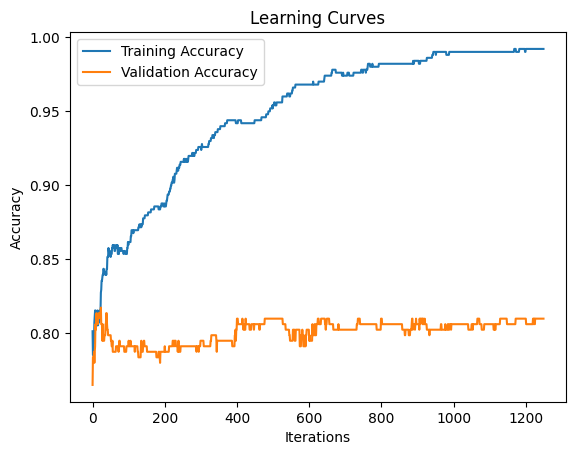

In [76]:
import matplotlib.pyplot as plt


# Get logged metrics
metrics = cat_cls.get_evals_result()

# Plot learning curves
plt.plot(metrics['learn']['Accuracy'], label='Training Accuracy')
plt.plot(metrics['validation']['Accuracy'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves')
plt.show()

CURRENTLY DOING 2500 ITERATIONS: TEST RESULTS AT A SMALL AMOUNT OF INTERATIONS (50), THEN TEST (250) 10%, THEN (500), THEN (1250) 50%!!!!!!!!!!! WHERE DOES MY MEAN OF VAL ACCUARCY ENDS UP. WE WANT TO SEE AT WHAT POINT DO WE NOT SPEND 30 MIN RUNNING IT AND STILL ACHIEVING THE BEST POSSIBLE OUTCOME. AT WHAT POINT HAVE WE ACHIEVED WHAT WE SET OUT FOR. AT 1250 IT HITS CLOSE TO ONE. TRAINING ACCUARACY SHOULD HIT ONE BUT ALSO WANT VAL ACCUARCY TO BE INCHING UP ALONG THE WAY TO BE MORE ACCURATE. (CLOSER TO EACH OTHER BUT TRAINING STILL CLOSE TO ONE). WE LOSE A BIT TRYING TO GET FROM 0-500, WHAT HAPPENS FROM 50 TO 250. REPEAT THE TWO ABOVE THIS TO GET MORE CHARTS.

In [77]:
%pip install -Uq upgini catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.0/283.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.2/447.2 kB 21.6 MB/s eta 0:00:00

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [79]:
# Define the model
model = Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Generate some example data for demonstration
import numpy as np
num_samples = 1000
num_features = 10
X_train = np.random.rand(num_samples, num_features)
y_train = np.random.randint(0, 10, num_samples)
X_val = np.random.rand(num_samples // 5, num_features)  # 20% for validation
y_val = np.random.randint(0, 10, num_samples // 5)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)



This was an attempted model. It does not perform well and thus the reason why I chose to do the catboost route previous to this.

In [ ]:
epochs=5
history = model.fit(
  train_ds, # Assuming 'train_ds' and 'val_ds' are defined elsewhere
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0874 - loss: 2.3233 - val_accuracy: 0.0950 - val_loss: 2.3140
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1066 - loss: 2.2973 - val_accuracy: 0.0800 - val_loss: 2.3176
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1171 - loss: 2.2935 - val_accuracy: 0.0700 - val_loss: 2.3191
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1261 - loss: 2.2895 - val_accuracy: 0.0850 - val_loss: 2.3205
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1410 - loss: 2.2854 - val_accuracy: 0.0750 - val_loss: 2.3220


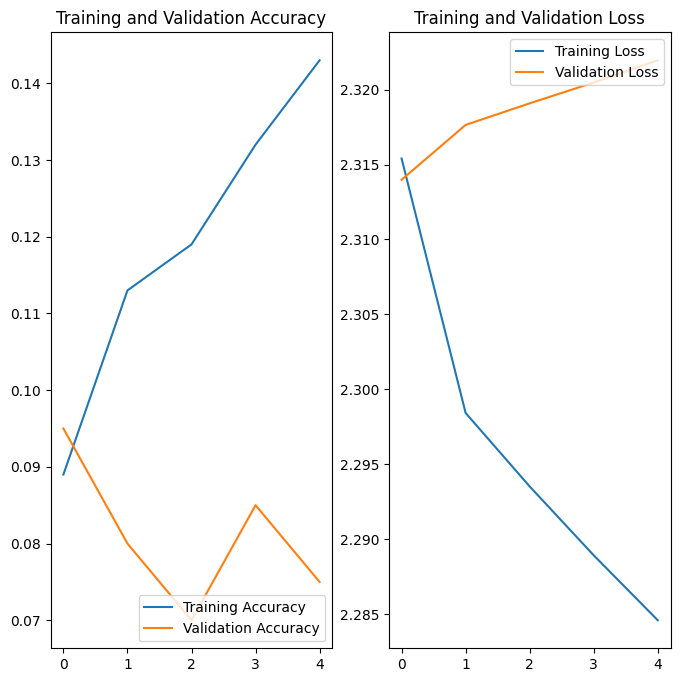

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs=10
history = model.fit(
  train_ds, # Assuming 'train_ds' and 'val_ds' are defined elsewhere
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1485 - loss: 2.2795 - val_accuracy: 0.1250 - val_loss: 2.3013
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1533 - loss: 2.2757 - val_accuracy: 0.1350 - val_loss: 2.3003
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1598 - loss: 2.2720 - val_accuracy: 0.1300 - val_loss: 2.2986
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1634 - loss: 2.2681 - val_accuracy: 0.1450 - val_loss: 2.2967
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1655 - loss: 2.2646 - val_accuracy: 0.1500 - val_loss: 2.2956
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1751 - loss: 2.2610 - val_accuracy: 0.1450 - val_loss: 2.2953
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1711 - loss: 2.2576 - val_accuracy: 0.1400 - val_loss: 2.2951
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1733 - loss: 2.2544 - val_accuracy: 0.1350 - val_loss:

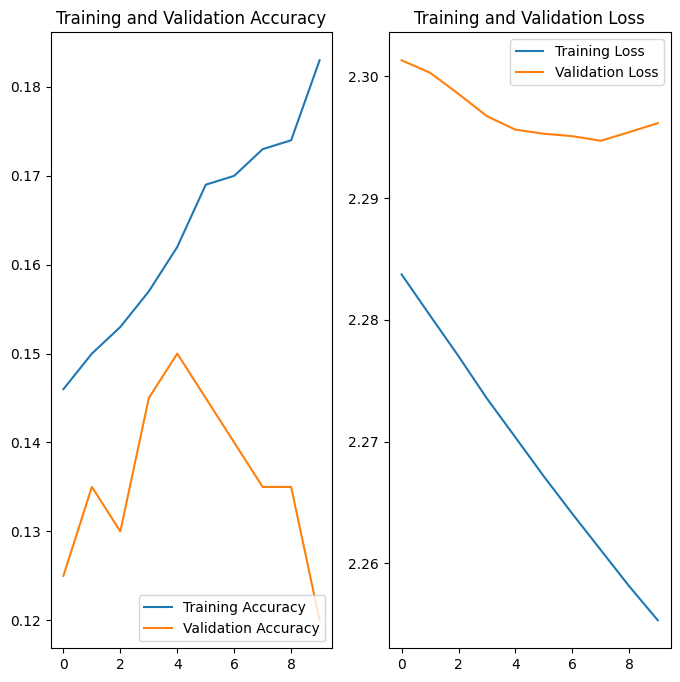

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs=15
history = model.fit(
  train_ds, # Assuming 'train_ds' and 'val_ds' are defined elsewhere
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1858 - loss: 2.2453 - val_accuracy: 0.1250 - val_loss: 2.2972
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1860 - loss: 2.2422 - val_accuracy: 0.1250 - val_loss: 2.2977
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1841 - loss: 2.2388 - val_accuracy: 0.1300 - val_loss: 2.2977
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1832 - loss: 2.2357 - val_accuracy: 0.1250 - val_loss: 2.2978
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1908 - loss: 2.2329 - val_accuracy: 0.1300 - val_loss: 2.2981
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1903 - loss: 2.2298 - val_accuracy: 0.1300 - val_loss: 2.2983
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1908 - loss: 2.2270 - val_accuracy: 0.1250 - val_loss: 2.2988
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1958 - loss: 2.2241 - val_accuracy: 0.1300 - val_loss:

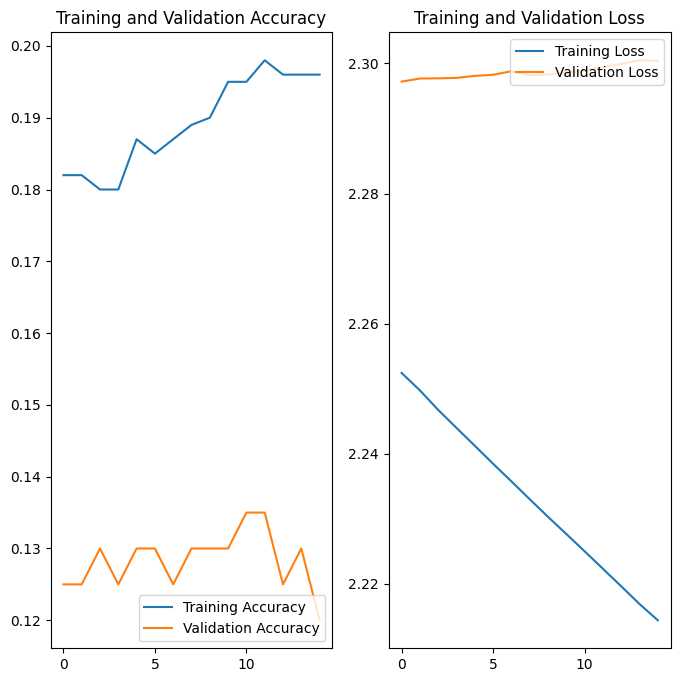

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2022 - loss: 2.2024 - val_accuracy: 0.1250 - val_loss: 2.3014
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2032 - loss: 2.1995 - val_accuracy: 0.1300 - val_loss: 2.3014
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2060 - loss: 2.1970 - val_accuracy: 0.1250 - val_loss: 2.3021
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2101 - loss: 2.1942 - val_accuracy: 0.1250 - val_loss: 2.3025
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2166 - loss: 2.1914 - val_accuracy: 0.1200 - val_loss: 2.3028
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2173 - loss: 2.1888 - val_accuracy: 0.1200 - val_loss: 2.3032
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2194 - loss: 2.1862 - val_accuracy: 0.1200 - val_loss: 2.3040
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2216 - loss: 2.1834 - val_accuracy: 0.1200 - val_loss:

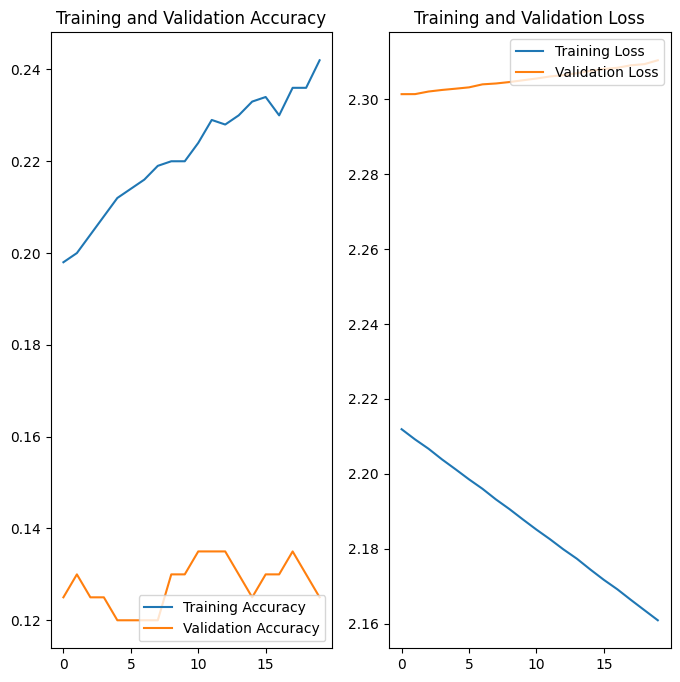

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 24
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2461 - loss: 2.1488 - val_accuracy: 0.1300 - val_loss: 2.3112
Epoch 2/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2433 - loss: 2.1462 - val_accuracy: 0.1300 - val_loss: 2.3110
Epoch 3/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2426 - loss: 2.1433 - val_accuracy: 0.1350 - val_loss: 2.3121
Epoch 4/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2437 - loss: 2.1407 - val_accuracy: 0.1250 - val_loss: 2.3124
Epoch 5/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2469 - loss: 2.1381 - val_accuracy: 0.1350 - val_loss: 2.3137
Epoch 6/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2432 - loss: 2.1353 - val_accuracy: 0.1250 - val_loss: 2.3139
Epoch 7/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2431 - loss: 2.1326 - val_accuracy: 0.1250 - val_loss: 2.3152
Epoch 8/24
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2476 - loss: 2.1297 - val_accuracy: 0.1250 - val_loss:

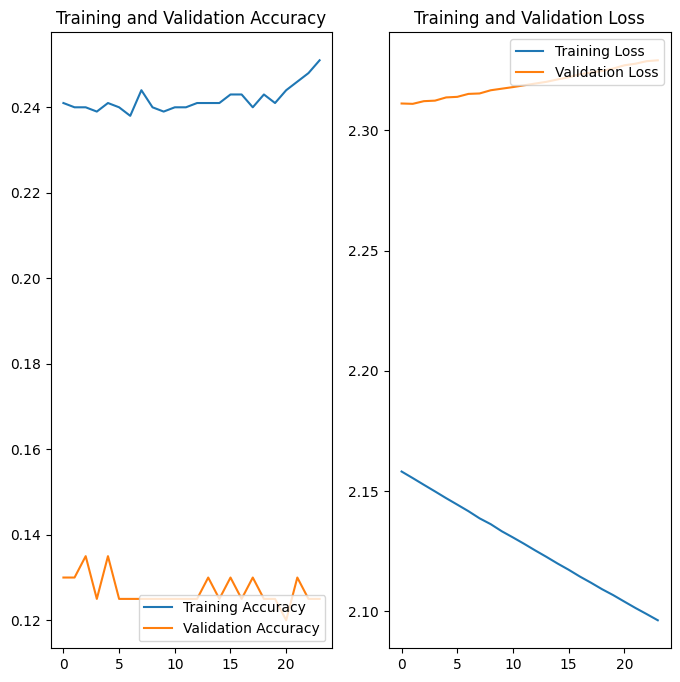

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2510 - loss: 2.0859 - val_accuracy: 0.1250 - val_loss: 2.3307
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2508 - loss: 2.0832 - val_accuracy: 0.1250 - val_loss: 2.3318
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2563 - loss: 2.0810 - val_accuracy: 0.1200 - val_loss: 2.3326
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2532 - loss: 2.0785 - val_accuracy: 0.1200 - val_loss: 2.3334
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2555 - loss: 2.0757 - val_accuracy: 0.1250 - val_loss: 2.3350
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2560 - loss: 2.0739 - val_accuracy: 0.1250 - val_loss: 2.3355
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2622 - loss: 2.0711 - val_accuracy: 0.1250 - val_loss: 2.3361
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2622 - loss: 2.0690 - val_accuracy: 0.1250 - val_loss:

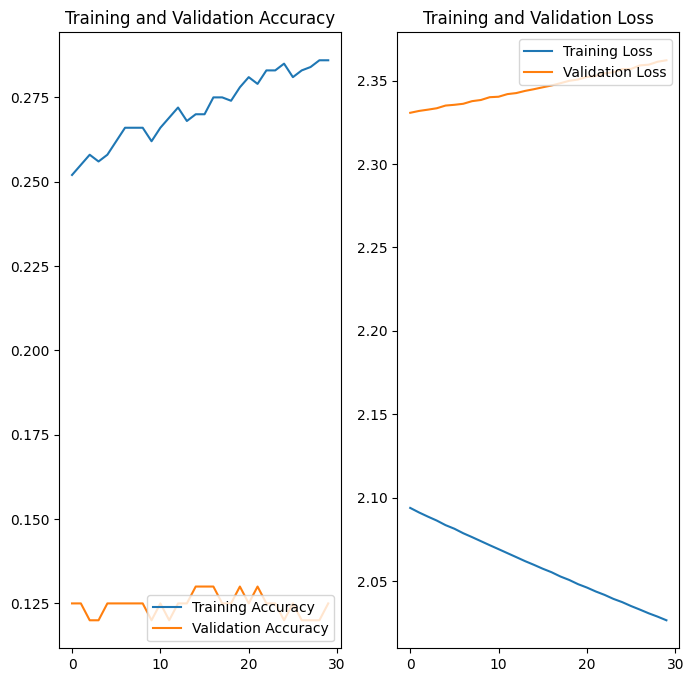

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2719 - loss: 2.0189 - val_accuracy: 0.1250 - val_loss: 2.3635
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2747 - loss: 2.0172 - val_accuracy: 0.1250 - val_loss: 2.3646
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2746 - loss: 2.0151 - val_accuracy: 0.1250 - val_loss: 2.3657
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2788 - loss: 2.0135 - val_accuracy: 0.1250 - val_loss: 2.3670
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2765 - loss: 2.0110 - val_accuracy: 0.1250 - val_loss: 2.3685
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2795 - loss: 2.0094 - val_accuracy: 0.1250 - val_loss: 2.3688
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2793 - loss: 2.0072 - val_accuracy: 0.1250 - val_loss: 2.3713
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2847 - loss: 2.0053 - val_accuracy: 0.1250 - val_loss:

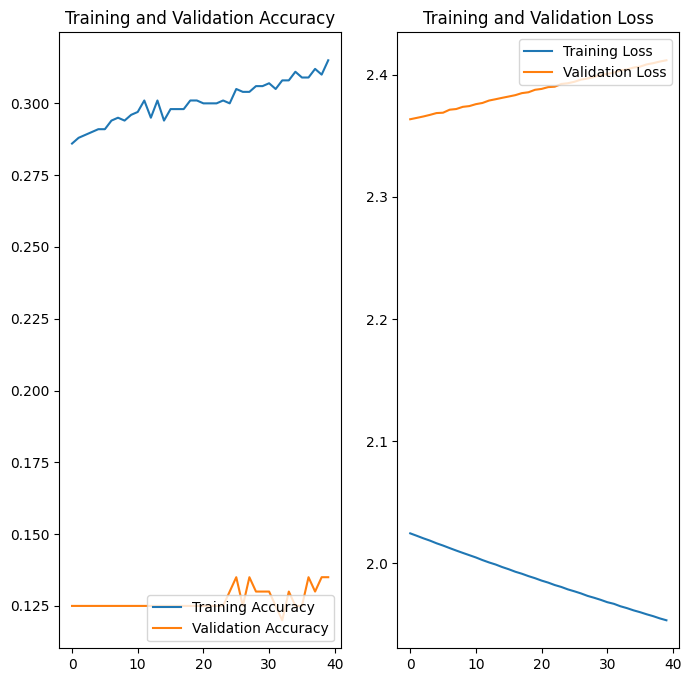

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()